## Image Color Normalization

This notebook implements the image color normalization process described in appendix 3 of the paper ["Detecting Cancer Metastases on Gigapixel Pathology Images"](https://arxiv.org/abs/1703.02442).

The code obviously needs to be consolidated and refactored into a class, I haven't had the time to do that yet.

In [240]:
import numpy as np
import h5py
from scipy.optimize import curve_fit
from scipy.linalg import sqrtm
from matplotlib import pyplot as plt
%matplotlib inline

Load the dataset and visualize a few samples:

In [2]:
hdf5_images_path = '../../Downloads/camelyonpatch_level_2_split_train_x.h5'
hdf5_images_file = h5py.File(hdf5_images_path, 'r')
images = hdf5_images_file['x']

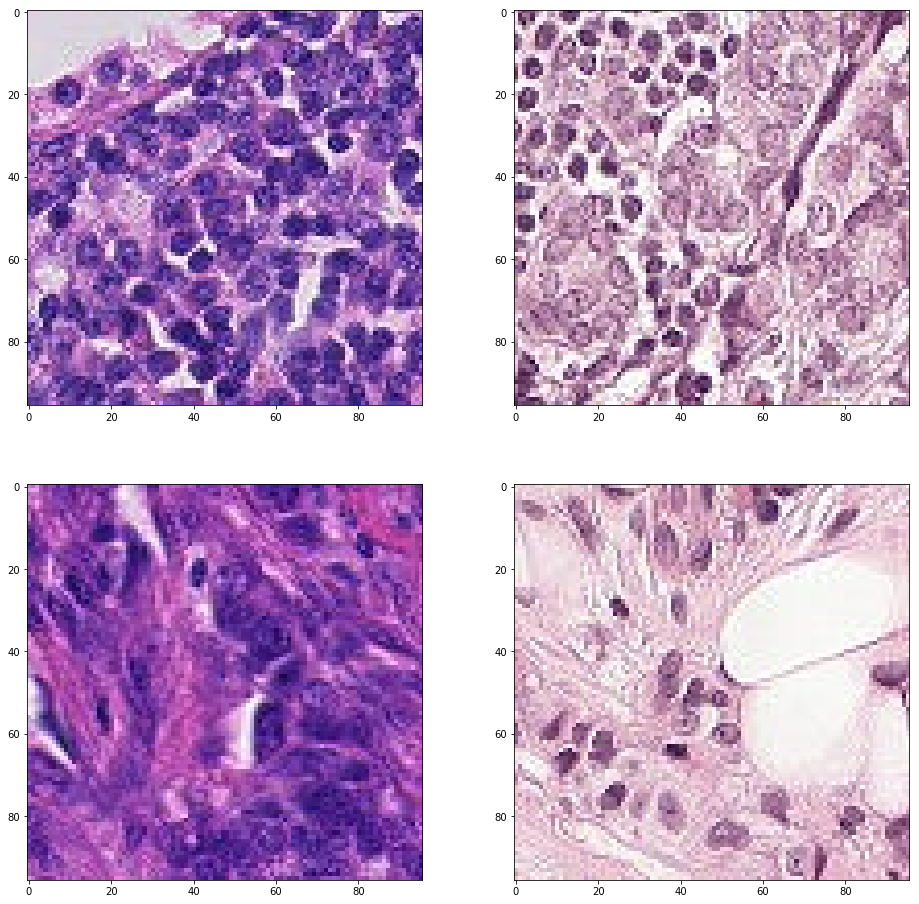

In [4]:
i = 0
m = 2
n = 2

fig, cells = plt.subplots(m, n, figsize=(n*8,m*8))
cells[0,0].imshow(images[i])
cells[0,1].imshow(images[i+1])
cells[1,0].imshow(images[i+2])
cells[1,1].imshow(images[i+3])

We need conversion functions between RGB and HSI (hue, saturation, intensity).

In [262]:
def convert_rgb_to_hsi(image):
    '''
    Converts images from the RGB to the HSI color space.
    '''
    
    r = image[:,:,0].astype(np.float)
    g = image[:,:,1].astype(np.float)
    b = image[:,:,2].astype(np.float)
    
    d_r = -np.log((r+1)/257)
    d_g = -np.log((g+1)/257)
    d_b = -np.log((b+1)/257)
    
    d   = (d_r + d_g + d_b) / 3
    c_x = d_r / d - 1
    c_y = (d_g - d_b) / (np.sqrt(3) * d)
    
    return np.stack((c_x, c_y, d), axis=-1)

In [307]:
def convert_hsi_to_rgb(image):
    '''
    Converts images from the HSI to the RGB color space.
    '''
    
    c_x = image[:,:,0]
    c_y = image[:,:,1]
    d   = image[:,:,2]
    
    d_r = (c_x + 1) * d
    d_g = 0.5 * d * (2 - c_x + np.sqrt(3) * c_y)
    d_b = 0.5 * d * (2 - c_x - np.sqrt(3) * c_y)
    
    r = np.exp(-d_r) * 257 - 1
    g = np.exp(-d_g) * 257 - 1
    b = np.exp(-d_b) * 257 - 1
    
    rgb_image = np.stack((r, g, b), axis=-1).astype(np.uint8)
    
    return rgb_image

Compile a vector of HSI channel values over the dataset. These are the sets of points to which we will fit the Gaussian density functions and from which we will compute the statistical moments.

In [263]:
def compile_hsi_feature_vectors(hdf5_images_path, dataset='x', start=0, end=1000):
    '''
    Returns two vectors ((c_x, c_y)_i and (d)_i) with the values of the HSI color channels
    over a portion of the dataset.
    '''

    hdf5_images_file = h5py.File(hdf5_images_path, 'r')
    images = hdf5_images_file[dataset]
    
    if end is None:
        end = len(images)

    cxcy = []
    d = []

    for i in range(start, end):
        image_hsi = convert_rgb_to_hsi(images[i])
        cxcy.append(np.reshape(image_hsi[:,:,:2], (-1,2)))
        d.append(np.reshape(image_hsi[:,:,2], (-1,)))
    cxcy = np.concatenate(cxcy, axis=0)
    d = np.concatenate(d, axis=0)

    return cxcy, d

In [148]:
cxcy, d = compile_hsi_feature_vectors(hdf5_images_path='../../Downloads/camelyonpatch_level_2_split_train_x.h5',
                                      dataset='x',
                                      start=0,
                                      end=1000)

Plot the (c_x, c_y) plane to get an idea of the underlying distribution. These are roughly 10 million points.

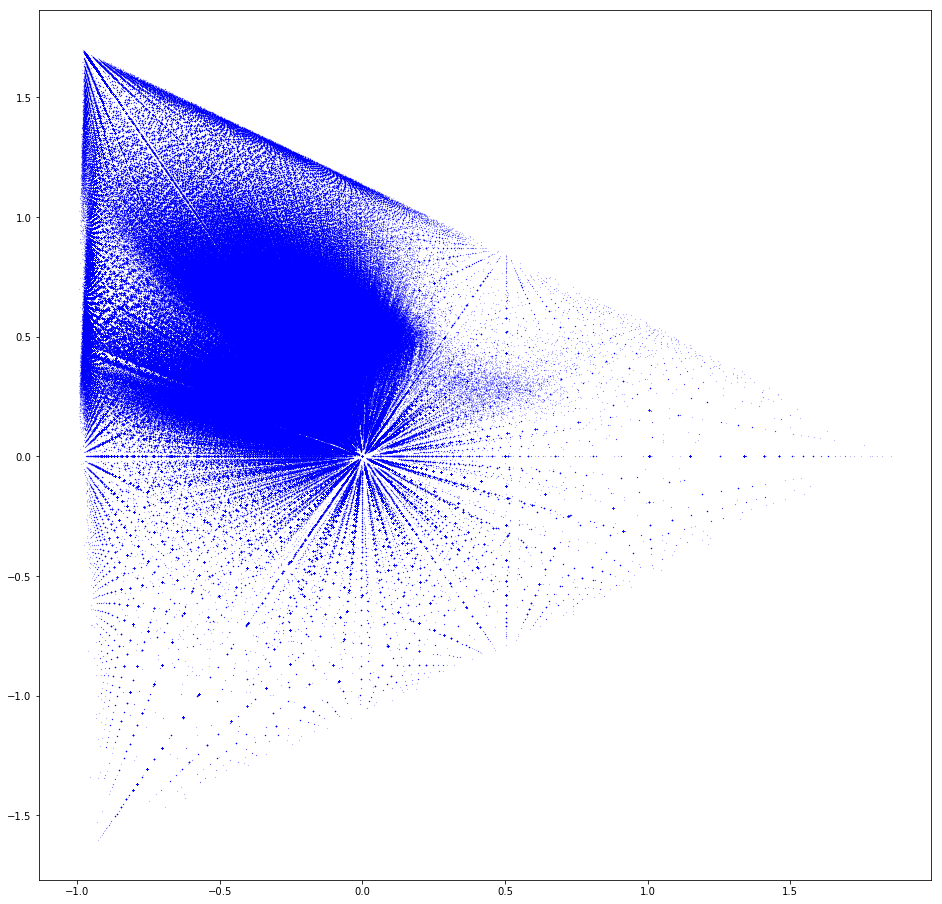

In [146]:
plt.figure(figsize = (16,16))
plt.plot(cxcy[:,0], cxcy[:,1], 'bo', ms=0.1)

In [209]:
def histogram_2d(points, bins=200, normed=True):
    '''
    Returns the bin center points and corresponding histogram counts of a set of 2D points.
    This is just a wrapper for `numpy.histogram2d()` that returns bin center points rather
    than bin edges and reshapes the data into 1D vectors.
    '''
    
    H, yedges, xedges = np.histogram2d(x=points[:,1], y=points[:,0], bins=bins, normed=True)
    
    # Compute the bin center points.
    x_centroids = (xedges + (xedges[1] - xedges[0]))[:-1]
    y_centroids = (yedges + (yedges[1] - yedges[0]))[:-1]
    
    # Reshape into 1D vectors.
    vec = np.reshape(np.stack(np.meshgrid(x_centroids, y_centroids), axis=-1), (-1, 2))
    values = np.reshape(H, (-1,))
    
    return vec, values

In [210]:
def histogram_1d(x, bins=200, normed=True):
    '''
    Same as `histogram_2d()` but for the 1D case.
    '''
    
    hist, bin_edges = np.histogram(x, bins=bins, density=normed)
    
    # Compute the bin center points.
    bin_centroids = (bin_edges + (bin_edges[1] - bin_edges[0]))[:-1]
    
    return hist, bin_centroids

Plot a histogram of the density channel.

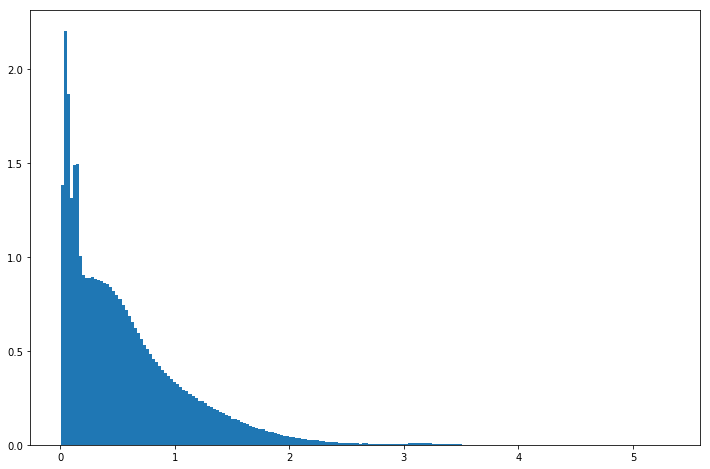

In [204]:
#hist, binedges = np.histogram(d, bins=200)
plt.figure(figsize = (12,8))
hist, binedges, patches = plt.hist(d, bins=200, normed=True)

And one for the (c_x, c_y) channels:

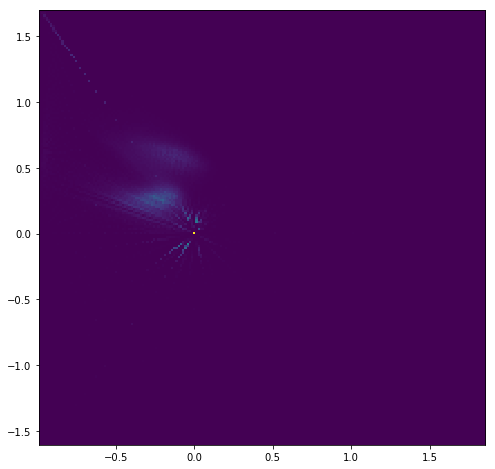

In [199]:
plt.figure(figsize = (8,8))
H, xedges, yedges, axes_image = plt.hist2d(x=cxcy[:,0], y=cxcy[:,1], bins=200, normed=True)

We need Gaussian density functions in 1D and 2D to fit to the histogram data.

In [223]:
def gaussian_density_2d(vec, mu_x, mu_y, sigma_x, sigma_y, sigma_xy):
    
    x, y     = vec
    rho      = sigma_xy / (sigma_x * sigma_y) # Correlation coefficient
    C        = 1 / (2 * np.pi * sigma_x * sigma_y * np.sqrt(1 - rho**2)) # Scaling constant
    x_std    = (x - mu_x) / sigma_x # Standardized x
    y_std    = (y - mu_y) / sigma_y # Standardized y
    gaussian = np.exp(-1 / (2 * (1 - rho**2)) * (x_std**2 + y_std**2 - 2 * rho * x_std * y_std)) # Unscaled Gaussian function
    return C * gaussian # Scaled Gaussian function

def gaussian_density_1d(x, mu, sigma):
    
    C        = 1 / (sigma * np.sqrt(2 * np.pi)) # Scaling constant
    x_std    = (x - mu) / sigma # Standardized x
    gaussian = np.exp(-1/2 * x_std**2) # Unscaled Gaussian function
    return C * gaussian # Scaled Gaussian function

Let's fit the Gaussians to the data:

In [233]:
def fit_gaussian_2d(points, bins=200, p0=None):
    '''
    Fits a 2D gaussian density function to a set of 2D points
    and returns the mean vector and covariance matrix.
    '''
    
    vec, values = histogram_2d(points=points, bins=bins, normed=True)

    popt, pcov = curve_fit(f=gaussian_density_2d,
                           xdata=(vec[:,0],vec[:,1]),
                           ydata=values,
                           p0=p0,
                           bounds=([-np.inf, -np.inf, 0.001, 0.001, -np.inf],
                                   [np.inf, np.inf, np.inf, np.inf, np.inf]))
    
    mu    = np.array([[popt[0]], [popt[1]]])
    sigma = np.array([[popt[2]**2, popt[4]], [popt[4], popt[3]**2]])
    
    return mu, sigma

def fit_gaussian_1d(x, bins=200, p0=None):
    '''
    Same as `fit_gaussian_2d()`, but for the 1D case.
    '''
    
    hist, bin_centroids = histogram_1d(x=x, bins=bins, normed=True)

    popt, pcov = curve_fit(f=gaussian_density_1d,
                           xdata=bin_centroids,
                           ydata=hist,
                           p0=p0,
                           bounds=([-np.inf, 0.001], [np.inf, np.inf]))
    
    mu  = popt[0]
    var = popt[1]**2
    
    return mu, var

In [234]:
mu_cxcy, sigma_cxcy = fit_gaussian_2d(points=cxcy, bins=200, p0=(-0.25, 0.25, 0.2, 0.2, 0))

mu_d, var_d = fit_gaussian_1d(x=d, bins=200, p0=(0.3, 0.3))

print("mu_cxcy:")
print(mu_cxcy)
print("sigma_cxcy:")
print(sigma_cxcy)
print()
print("[mu_d, var_d]:")
print(mu_d, var_d)

mu_cxcy:
[[-0.22938269]
 [ 0.30940757]]
sigma_cxcy:
[[ 0.0276325  -0.00250663]
 [-0.00250663  0.04898879]]

[mu_d, var_d]:
0.21194804033708756 0.13341948720932434


Compute the statistical moments.

In [237]:
def compute_moments_2d(points):
    
    mu    = np.mean(points, axis=0)
    sigma = np.cov(points, rowvar=False)
    
    return mu, sigma

def compute_moments_1d(x):
    
    mu  = np.mean(x)
    var = np.var(x)
    
    return mu, var

In [239]:
mu_cxcy_stat, sigma_cxcy_stat = compute_moments_2d(cxcy)

mu_d_stat, var_d_stat = compute_moments_1d(d)

print("mu_cxcy_stat:")
print(mu_cxcy_stat)
print("sigma_cxcy_stat:")
print(sigma_cxcy_stat)
print()
print("[mu_d_stat, var_d_stat]:", mu_d_stat, var_d_stat)

mu_cxcy_stat:
[-0.28209481  0.37306939]
sigma_cxcy_stat:
[[ 0.0511795  -0.02839332]
 [-0.02839332  0.0924293 ]]

[mu_d_stat, var_d_stat]: 0.5691206245268953 0.2712900226746665


Compute the Monge-Kantorovitch operator that we need for the normalization operation. As before, we need to do this once in 2D for the (c_x, c_y) channels and once in 1D for the density channel.

In [249]:
def compute_monge_kantorovitch_operator_2d(sigma, sigma_ref):
    
    sigma_sqrt     = sqrtm(sigma)
    sigma_sqrt_inv = np.linalg.inv(sigma_sqrt)
    
    T1      = np.matmul(np.matmul(sigma_sqrt, sigma_ref), sigma_sqrt)
    T1_sqrt = sqrtm(T1)
    T       = np.matmul(np.matmul(sigma_sqrt_inv, T1_sqrt), sigma_sqrt_inv)
    
    return T

def compute_monge_kantorovitch_operator_1d(var, var_ref):
    
    var_sqrt = np.sqrt(var)
    var_sqrt_inv = 1 / var_sqrt
    
    T1      = var_sqrt * var_ref * var_sqrt
    T1_sqrt = np.sqrt(T1)
    T       = var_sqrt_inv * T1_sqrt * var_sqrt_inv
    
    return T

In [250]:
T_cxcy = compute_monge_kantorovitch_operator_2d(sigma=sigma_cxcy, sigma_ref=sigma_cxcy_stat)
T_d = compute_monge_kantorovitch_operator_1d(var=var_d, var_ref=var_d_stat)

print("Monge-Kantorovitch Operator for (cx, cy):\n")
print(T_cxcy)
print()
print("Monge-Kantorovitch Operator for D:\n")
print(T_d)

Monge-Kantorovitch Operator for (cx, cy):

[[ 1.30401125 -0.233313  ]
 [-0.233313    1.35047968]]

Monge-Kantorovitch Operator for D:

1.425959783926912


Using all the operators and moments computed above, this is the function that actually normalizes images in the HSI space:

In [281]:
def normalize_hsi_2d(hsi_image, T, mu, mu_ref):
    
    cxcy = hsi_image[:,:,:2]

    cxcy_centered   = cxcy - mu.T
    cxcy_normalized = np.matmul(cxcy_centered, T.T)
    cxcy_prime      = cxcy_normalized + mu_ref.T
    
    return cxcy_prime

def normalize_hsi_1d(hsi_image, T, mu, mu_ref):
    
    d = hsi_image[:,:,2]
    
    d_centered   = d - mu
    d_normalized = d_centered * T
    d_prime      = d_normalized + mu_ref
    
    return d_prime

def normalize_hsi_image(hsi_image, T_cxcy, T_d, mu_cxcy, mu_d, mu_ref_cxcy, mu_ref_d):
    
    cxcy_prime = normalize_hsi_2d(hsi_image, T_cxcy, mu_cxcy, mu_ref_cxcy)
    d_prime    = normalize_hsi_1d(hsi_image, T_d, mu_d, mu_ref_d)
    
    normalized_image = np.stack((cxcy_prime[:,:,0], cxcy_prime[:,:,1], d_prime), axis=-1)
    
    return normalized_image

Using all the parts above, this is the color normalizer function:

In [308]:
def normalize_colors(image, T_cxcy, T_d, mu_cxcy, mu_d, mu_ref_cxcy, mu_ref_d):
    
    hsi_image            = convert_rgb_to_hsi(image)
    print(hsi_image.dtype)
    print(np.max(hsi_image))
    print(np.min(hsi_image))
    hsi_image_normalized = normalize_hsi_image(hsi_image, T_cxcy, T_d, mu_cxcy, mu_d, mu_ref_cxcy, mu_ref_d)
    rgb_image_normalized = convert_hsi_to_rgb(hsi_image_normalized)
    
    return rgb_image_normalized

In [315]:
color_normalized_image_0 = normalize_colors(images[0],
                                            T_cxcy,
                                            T_d,
                                            mu_cxcy,
                                            mu_d,
                                            mu_ref_cxcy=mu_cxcy_stat,
                                            mu_ref_d=mu_d_stat)

color_normalized_image_1 = normalize_colors(images[1],
                                            T_cxcy,
                                            T_d,
                                            mu_cxcy,
                                            mu_d,
                                            mu_ref_cxcy=mu_cxcy_stat,
                                            mu_ref_d=mu_d_stat)

float64
3.1221770197669727
-0.9671666260249671
float64
2.929271699997359
-1.3677988374924472


In [316]:
print(color_normalized_image.dtype)
print(np.max(color_normalized_image))
print(np.min(color_normalized_image))

uint8
255
0


The normalized images doesn't look right.
1. They have artefacts in them.
2. They are way too different from each other.

Some intensities seem to get clamped to [0, 255] in the conversion from HSI back to RGB. Need to figure out why these value

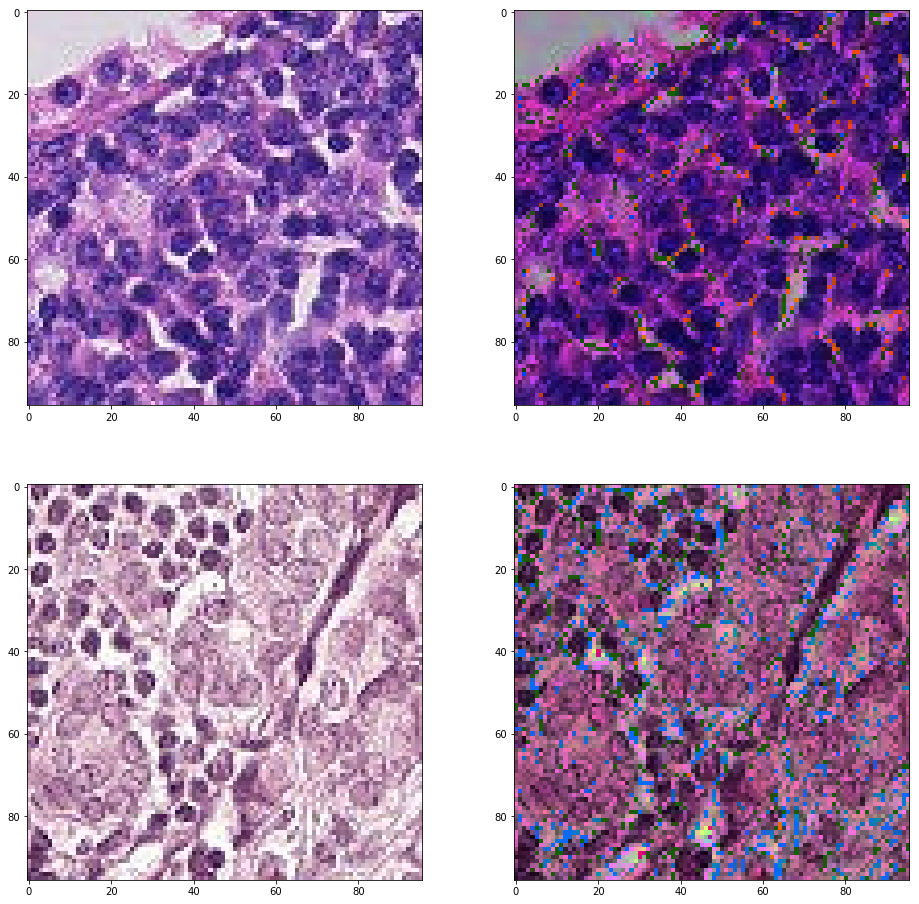

In [317]:
m = 2
n = 2

fig, cells = plt.subplots(m, n, figsize=(n*8,m*8))
cells[0,0].imshow(images[0])
cells[0,1].imshow(color_normalized_image_0)
cells[1,0].imshow(images[1])
cells[1,1].imshow(color_normalized_image_1)

This here was just a test to make sure that my 2D Gaussian density function is right:

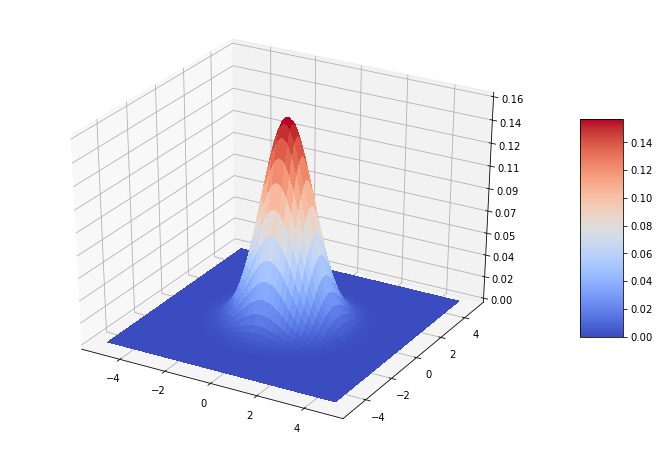

In [293]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure(figsize=(12,8))
ax = fig.gca(projection='3d')

# Make some data.
X = np.arange(-5, 5, 0.1)
Y = np.arange(-5, 5, 0.1)
X, Y = np.meshgrid(X, Y)
Z = gaussian_density_2d((X,Y), mu_x=0, mu_y=0, sigma_x=1, sigma_y=1, sigma_xy=0)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()